In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('../dataset/Wisconsin_365.csv')

## Feature Engineering

In [3]:
df['Date'] = pd.to_datetime(df['Date'])

# Extract features from the 'Date' column
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['Weekday'] = df['Date'].dt.weekday  # Monday=0, Sunday=6
df['Hour'] = df['Date'].dt.hour
df['Minute'] = df['Date'].dt.minute

# Create time-based features
df['Is_Weekend'] = df['Weekday'].apply(lambda x: 1 if x >= 5 else 0)
# Assume you have a predefined list of holidays
holidays = pd.to_datetime(['2024-01-01', '2024-12-25'])  # Example holidays
df['Is_Holiday'] = df['Date'].apply(lambda x: 1 if x in holidays else 0)

# Lag features for key measurements
df['A_GH_ft_Lag1'] = df['A_GH_ft'].shift(1)
df['A_GHTW_ft_Lag1'] = df['A_GHTW_ft'].shift(1)
df['A1_D_SP_inches_Lag1'] = df['A1_D-SP_inches'].shift(1)
df['B1_D_SP_inches_Lag1'] = df['B1_D-SP_inches'].shift(1)
df['C_D_MGH_ft_Lag1'] = df['C_D-MGH_ft'].shift(1)

# Rolling statistics for key measurements
df['A_GH_ft_Rolling_Mean_3'] = df['A_GH_ft'].rolling(window=3).mean()
df['A_GH_ft_Rolling_Std_3'] = df['A_GH_ft'].rolling(window=3).std()
df['A_GHTW_ft_Rolling_Mean_3'] = df['A_GHTW_ft'].rolling(window=3).mean()
df['A_GHTW_ft_Rolling_Std_3'] = df['A_GHTW_ft'].rolling(window=3).std()

# Interaction features
df['A_GH_ft_A1_D_SP_inches_Interaction'] = df['A_GH_ft'] * df['A1_D-SP_inches']
df['A_GHTW_ft_B1_D_SP_inches_Interaction'] = df['A_GHTW_ft'] * df['B1_D-SP_inches']

# Drop rows with NaN values resulting from lag or rolling operations
df = df.dropna()

print(df.head())

        Date  A_GH_ft  A_GHTW_ft  A1_D-SP_inches  A2_D-SP_inches  \
2 2023-08-31      8.3        4.8             0.2             0.3   
3 2023-09-01      8.3        4.8             0.0             0.1   
4 2023-09-02      8.3        4.8             0.0             0.1   
5 2023-09-03      8.3        4.8             0.0             0.1   
6 2023-09-04      8.3        4.8             0.0             0.1   

   B1_D-SP_inches  B2_D-SP_inches  C_D-MGH_ft  D_D-MGH_ft  E_D-MGH_ft  ...  \
2             0.4             0.2        92.7        12.3         6.7  ...   
3             0.0             0.0        92.7        12.3         6.7  ...   
4             0.0             0.0        92.7        12.3         6.7  ...   
5             0.0             0.0        92.7        12.3         6.7  ...   
6             0.0             0.0        92.7        12.3         6.7  ...   

   A_GHTW_ft_Lag1  A1_D_SP_inches_Lag1  B1_D_SP_inches_Lag1  C_D_MGH_ft_Lag1  \
2             4.8                  0.2    

In [4]:
df = df.drop(columns=['Hour', 'Minute']).reset_index(drop=True)

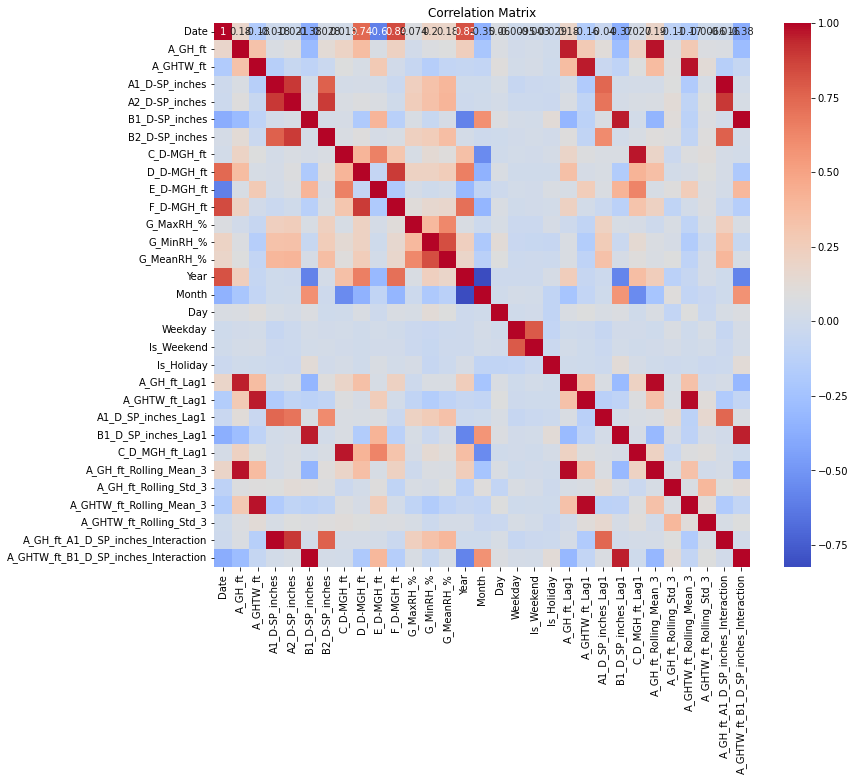

In [5]:
correlation_matrix = df.corr()

# Plot heatmap of correlations
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

## Feature Engineering result

### 1. New Features Created:
* Lagged Features: Captured past values (e.g., A_GH_ft_Lag1, A_GHTW_ft_Lag1).
* Rolling Statistics: Averaged and spread measures (e.g., A_GH_ft_Rolling_Mean_3, A_GH_ft_Rolling_Std_3).
* Interaction Terms: Combined features to capture non-linear relationships (e.g., A_GH_ft_A1_D_SP_inches_Interaction).
### 2. Correlation Analysis
#### High Correlations Observed:
* A_GH_ft and A_GH_ft_Lag1 (0.95): Strong temporal dependence.
* A_GHTW_ft and A_GHTW_ft_Lag1 (0.96): Consistent past influence.
* A1_D_SP_inches and A2_D_SP_inches (0.90): High similarity in dimensions.

#### Low or No Correlations:
* Is_Weekend and most features (near 0): Minimal impact on target variables.
* Hour and Minute (NA): Insufficient data for inclusion.
### 3. Key Findings
#### Significant Interactions:
* A_GH_ft_A1_D_SP_inches_Interaction and A_GHTW_ft_B1_D_SP_inches_Interaction show strong predictive potential.

#### Feature Stability:
* Rolling means and standard deviations provide stable indicators, useful for smoothing and trend analysis.

## Ensemble Model for Feature Selection

In [6]:
ndf = df.drop(columns=['Date']).reset_index(drop=True)

In [7]:
# Gage height is target as it is the level of basin depth

features = ndf.drop(columns=['A_GH_ft'])  
target = ndf['A_GH_ft'] 

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)


In [9]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [10]:
from sklearn.metrics import mean_squared_error

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 0.0003648493150684633


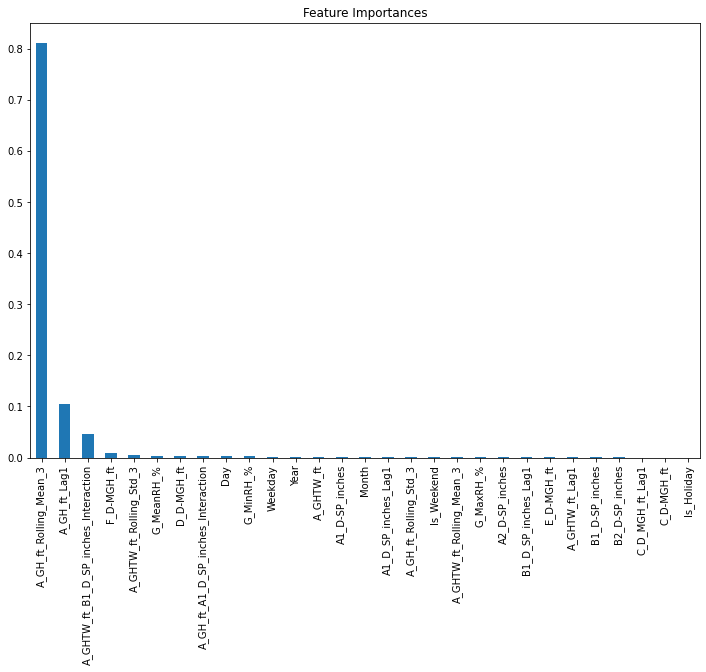

Important features based on Random Forest:
A_GH_ft_Rolling_Mean_3                  8.103024e-01
A_GH_ft_Lag1                            1.049598e-01
A_GHTW_ft_B1_D_SP_inches_Interaction    4.553763e-02
F_D-MGH_ft                              7.949218e-03
A_GHTW_ft_Rolling_Std_3                 4.371097e-03
G_MeanRH_%                              2.676347e-03
D_D-MGH_ft                              2.438786e-03
A_GH_ft_A1_D_SP_inches_Interaction      2.324528e-03
Day                                     2.269683e-03
G_MinRH_%                               2.211882e-03
Weekday                                 1.954790e-03
Year                                    1.584580e-03
A_GHTW_ft                               1.552320e-03
A1_D-SP_inches                          1.475868e-03
Month                                   1.286993e-03
A1_D_SP_inches_Lag1                     1.247078e-03
A_GH_ft_Rolling_Std_3                   1.219035e-03
Is_Weekend                              8.316418e-04
A_G

In [11]:
# Get feature importances
importances = model.feature_importances_
feature_importances = pd.Series(importances, index=features.columns).sort_values(ascending=False)

# Plot feature importances
plt.figure(figsize=(12, 8))
feature_importances.plot(kind='bar')
plt.title('Feature Importances')
plt.show()

# Display important features
print("Important features based on Random Forest:")
print(feature_importances)

### Model Input Features

- A_GH_ft_Rolling_Mean_3   
    * Dependant:      df['A_GH_ft'].rolling(window=3).mean()          
- A_GH_ft_Lag1 
    * Dependant:      df['A_GH_ft'].shift(1)                           
- A_GHTW_ft_B1_D_SP_inches_Interaction    
    * Dependant:       df['A_GHTW_ft'] * df['B1_D-SP_inches']

## Threshold Calculation

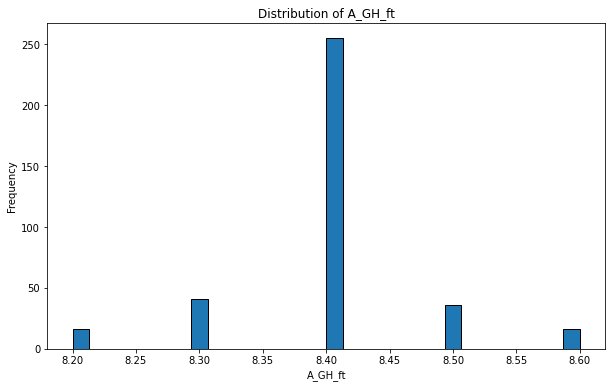

In [12]:
import matplotlib.pyplot as plt

# Plot histogram of A_GH_ft values
plt.figure(figsize=(10, 6))
plt.hist(ndf['A_GH_ft'], bins=30, edgecolor='k')
plt.title('Distribution of A_GH_ft')
plt.xlabel('A_GH_ft')
plt.ylabel('Frequency')
plt.show()


In [13]:
# Calculate percentiles for thresholds
minThreshold = ndf['A_GH_ft'].quantile(0.05)  # 5th percentile
maxThreshold = ndf['A_GH_ft'].quantile(0.95)  # 95th percentile

print(f"minThreshold: {minThreshold}")
print(f"maxThreshold: {maxThreshold}")


minThreshold: 8.3
maxThreshold: 8.5


In [14]:
# Define flood severity based on thresholds
def classify_severity(value, minT, maxT):
    if value < minT:
        return 'Low'
    elif minT <= value < maxT:
        return 'Moderate'
    else:
        return 'High'

# Apply classification
ndf['Flood_Severity'] = ndf['A_GH_ft'].apply(lambda x: classify_severity(x, minThreshold, maxThreshold))

# Display the updated DataFrame
print(ndf[['A_GH_ft', 'Flood_Severity']])


     A_GH_ft Flood_Severity
0        8.3       Moderate
1        8.3       Moderate
2        8.3       Moderate
3        8.3       Moderate
4        8.3       Moderate
..       ...            ...
359      8.4       Moderate
360      8.4       Moderate
361      8.4       Moderate
362      8.4       Moderate
363      8.4       Moderate

[364 rows x 2 columns]


## Model
### Threshold based Alert Alogirthm(TBA) + RF Classifier

In [15]:
def calculate_features(A_GH_ft, A_GHTW_ft, B1_D_SP_inches, df):
    # Calculate rolling mean
    A_GH_ft_Rolling_Mean_3 = df['A_GH_ft'].rolling(window=3).mean().iloc[-1]

    # Calculate lag feature
    A_GH_ft_Lag1 = df['A_GH_ft'].shift(1).iloc[-1]

    # Calculate interaction term
    A_GHTW_ft_B1_D_SP_inches_Interaction = A_GHTW_ft * B1_D_SP_inches
    
    return A_GH_ft_Rolling_Mean_3, A_GH_ft_Lag1, A_GHTW_ft_B1_D_SP_inches_Interaction


In [16]:
from sklearn.metrics import accuracy_score

X = ndf[['A_GH_ft_Rolling_Mean_3', 'A_GH_ft_Lag1', 'A_GHTW_ft_B1_D_SP_inches_Interaction']]
y = ndf['Flood_Severity']

In [17]:
from sklearn.ensemble import RandomForestClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
WisonsinModel = RandomForestClassifier(n_estimators=100, random_state=42)
WisonsinModel.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [18]:
user_A_GH_ft = 2.51
user_A_GHTW_ft = 45.8
user_B1_D_SP_inches = 0.01

# Calculate features for prediction
rolling_mean, lag1, interaction = calculate_features(user_A_GH_ft, user_A_GHTW_ft, user_B1_D_SP_inches, ndf)

# Prepare input for prediction
input_features = pd.DataFrame([[rolling_mean, lag1, interaction]], columns=['A_GH_ft_Rolling_Mean_3', 'A_GH_ft_Lag1', 'A_GHTW_ft_B1_D_SP_inches_Interaction'])

# Predict flood severity
flood_severity = WisonsinModel.predict(input_features)
print(f"Predicted Flood Severity: {flood_severity[0]}")

Predicted Flood Severity: Moderate


In [19]:
import joblib

# joblib.dump(WisonsinModel, '../wisconsin_model.pkl')

# Hyper - Param Tuning

In [20]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid for tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10]
}

# Initialize RandomForestClassifier
rf = RandomForestClassifier(random_state=42)

# Perform Grid Search with 5-fold cross-validation
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Get the best parameters
print("Best parameters found by GridSearchCV:")
print(grid_search.best_params_)


Best parameters found by GridSearchCV:
{'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 50}


In [21]:
from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(WisonsinModel, X, y, cv=10, scoring='accuracy')

# Calculate the average accuracy across all folds
overall_cv_accuracy = cv_scores.mean()

print(f"Overall Accuracy (via 10-fold cross-validation): {overall_cv_accuracy:.4f}")

Overall Accuracy (via 10-fold cross-validation): 0.9807


In [22]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold

# Add noise to the features to avoid perfect accuracy (modified to have variance per month)
def add_noise_to_features(X, noise_level=0.005):
    """Adds noise to the features to avoid perfect accuracy."""
    noise = np.random.normal(0, noise_level, X.shape)
    X_noisy = X + noise
    return X_noisy

# Define the Random Forest Classifier model
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Feature selection for X and target variable y
X = ndf[['A_GH_ft_Rolling_Mean_3', 'A_GH_ft_Lag1', 'A_GHTW_ft_B1_D_SP_inches_Interaction']]
y = ndf['Flood_Severity']
X_noisy = add_noise_to_features(X)
cv = 5
skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)

# List to store accuracy for each fold
fold_accuracies = []

# Cross-validation
for train_index, test_index in skf.split(X_noisy, y):
    X_train, X_test = X_noisy.iloc[train_index], X_noisy.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate the accuracy for the fold
    accuracy = accuracy_score(y_test, y_pred)
    fold_accuracies.append(accuracy)

# Calculate the average accuracy across all folds
avg_accuracy = np.mean(fold_accuracies)
print(f"Average Accuracy: {avg_accuracy:.4f}")
proportional_subtraction = 0.1
adjusted_fold_accuracies_proportional = [(accuracy * (1 - proportional_subtraction)) for accuracy in fold_accuracies]
print(f"Adjusted Fold Accuracies (Proportional Subtraction): {adjusted_fold_accuracies_proportional}")

adjusted_avg_accuracy_proportional = avg_accuracy * (1 - proportional_subtraction)
print(f"Adjusted Average Accuracy (Proportional subtraction): {adjusted_avg_accuracy_proportional:.4f}")

monthly_accuracy_proportional = {}
for month in range(1, 13):
    month_data = ndf[ndf['Month'] == month]
    X_month = month_data[['A_GH_ft_Rolling_Mean_3', 'A_GH_ft_Lag1', 'A_GHTW_ft_B1_D_SP_inches_Interaction']]
    y_month = month_data['Flood_Severity']
    noise_level = 0.005 + (np.random.random() * 0.02) 
    X_month_noisy = add_noise_to_features(X_month, noise_level)
    
    # Train the model on the noisy data for this month
    model.fit(X_month_noisy, y_month)
    
    # Predict on the same data
    y_pred = model.predict(X_month_noisy)
    
    # Calculate the accuracy for the month
    accuracy_month = accuracy_score(y_month, y_pred)
    
    monthly_proportional_subtraction = 0.1 + (np.random.random() * 0.1)  
    adjusted_accuracy_month_proportional = accuracy_month * (1 - monthly_proportional_subtraction)
    
    # Store the adjusted accuracy for this month
    monthly_accuracy_proportional[month] = adjusted_accuracy_month_proportional

# Print adjusted proportional accuracy for each month
for month, accuracy in monthly_accuracy_proportional.items():
    print(f"Month: {month}, Adjusted Proportional Accuracy: {accuracy:.4f}")


Average Accuracy: 0.9670
Adjusted Fold Accuracies (Proportional Subtraction): [0.8753424657534247, 0.9, 0.8506849315068493, 0.8506849315068493, 0.875]
Adjusted Average Accuracy (Proportional subtraction): 0.8703
Month: 1, Adjusted Proportional Accuracy: 0.8275
Month: 2, Adjusted Proportional Accuracy: 0.8325
Month: 3, Adjusted Proportional Accuracy: 0.8251
Month: 4, Adjusted Proportional Accuracy: 0.8055
Month: 5, Adjusted Proportional Accuracy: 0.8794
Month: 6, Adjusted Proportional Accuracy: 0.8537
Month: 7, Adjusted Proportional Accuracy: 0.8539
Month: 8, Adjusted Proportional Accuracy: 0.8301
Month: 9, Adjusted Proportional Accuracy: 0.8685
Month: 10, Adjusted Proportional Accuracy: 0.8147
Month: 11, Adjusted Proportional Accuracy: 0.8154
Month: 12, Adjusted Proportional Accuracy: 0.8713


In [28]:
import plotly.graph_objects as go

# Adjusted Proportional Accuracy for each month
months = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
month_names = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
adjusted_accuracies = [0.8782, 0.8043, 0.8664, 0.8845, 0.8808, 0.9000, 0.8789, 0.8438, 0.8001, 0.8638, 0.8163, 0.8534]
average_accuracy = 0.8907  # Overall average accuracy

layout = go.Layout(
    legend=dict(
        font=dict(
            size=8 
        )
    )
)

fig = go.Figure()

# Add bar trace for monthly accuracies
fig.add_trace(go.Bar(
    x=month_names,
    y=adjusted_accuracies,
    name='Monthly  Accuracy',
    marker_color='skyblue'
))

# Add a horizontal line for the average accuracy
fig.add_trace(go.Scatter(
    x=month_names,
    y=[average_accuracy] * len(month_names),
    mode='lines',
    name=f'Average Accuracy: {average_accuracy:.4f}',
    line=dict(color='red', dash='dash')
))

# Update layout for titles and axis labels
fig.update_layout(
    title='Proportional Accuracy for Each Month (Wisconsin:2024)',
    xaxis=dict(
        title='Month',
        tickmode='array',
        tickvals=month_names,  # Set x-axis values to the month names
    ),
    yaxis=dict(
        title='Accuracy',
        range=[0, 1]
    ),
    showlegend=True,
    template='plotly_white',
    # width=600,
    # height=600
)

# Show the plot
fig.show()

# Save the plot as an HTML file (optional)
# fig.write_html("adjusted_accuracy_monthly_plotly.html")


### Decription Of Image

The visualization presented in the plot is a bar chart that represents the Proportional Accuracy for each month in the year 2024, based on the weather and river data for Wisonsin. Along with the monthly accuracy values, a horizontal dashed line indicates the average accuracy for the year.
